Peak Center: 7.4
Peak Width (FWHM): 0.39999999999999947
Peak Height: 1000
Fitted Parameters:
  a = 804.9812095648464
  b = 7.540723661853103
  c = 0.2534624773777107
Peak Start: 7.1
Peak Stop: 8.0


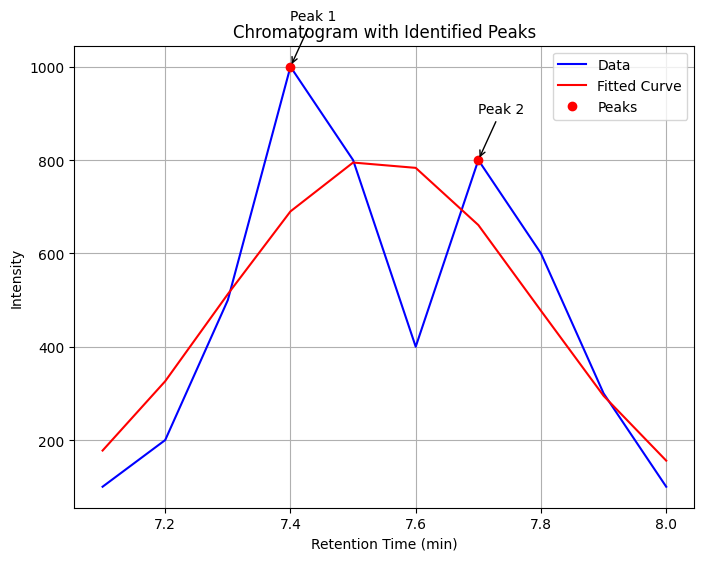

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def gaussian(x, a, b, c):
    return a * np.exp(-(x - b)**2 / (2 * c**2))

# Example data
retention_time = np.array([7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0])
intensity = np.array([100, 200, 500, 1000, 800, 400, 800, 600, 300, 100])

# Find all peaks
peak_indices, _ = find_peaks(intensity)
peak_centers = retention_time[peak_indices]

# Perform analysis on the largest peak
largest_peak_idx = np.argmax(intensity[peak_indices])
peak_center = peak_centers[largest_peak_idx]

# Step 2: Calculate the peak width (FWHM)
half_max = intensity[peak_indices[largest_peak_idx]] / 2
left_idx = np.where(intensity[:peak_indices[largest_peak_idx]] < half_max)[0][-1]
right_idx = np.where(intensity[peak_indices[largest_peak_idx]:] < half_max)[0][0] + peak_indices[largest_peak_idx]
fwhm = retention_time[right_idx] - retention_time[left_idx]

# Step 3: Determine the peak height
peak_height = intensity[peak_indices[largest_peak_idx]]

# Step 4: Perform Gaussian fitting
p0 = [peak_height, peak_center, fwhm/2.35482]  # Initial parameters
popt, _ = curve_fit(gaussian, retention_time, intensity, p0=p0)

# Extract the fitted parameters
a, b, c = popt
fitted_curve = gaussian(retention_time, a, b, c)

# Identify the start and stop points of the peak
threshold = 0.01 * peak_height  # Adjust the threshold as needed
start_idx = np.where(fitted_curve > threshold)[0][0]
stop_idx = np.where(fitted_curve > threshold)[0][-1]
peak_start = retention_time[start_idx]
peak_stop = retention_time[stop_idx]

print("Peak Center:", peak_center)
print("Peak Width (FWHM):", fwhm)
print("Peak Height:", peak_height)
print("Fitted Parameters:")
print("  a =", a)
print("  b =", b)
print("  c =", c)
print("Peak Start:", peak_start)
print("Peak Stop:", peak_stop)

# Plot the data and the identified peaks
plt.figure(figsize=(8, 6))
plt.plot(retention_time, intensity, 'b-', label='Data')
plt.plot(retention_time, fitted_curve, 'r-', label='Fitted Curve')
plt.plot(peak_centers, intensity[peak_indices], 'ro', label='Peaks')

# Annotate the peaks
for i, peak_center in enumerate(peak_centers):
    plt.annotate(f'Peak {i+1}', xy=(peak_center, intensity[peak_indices[i]]),
                 xytext=(peak_center, intensity[peak_indices[i]]+100),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.xlabel('Retention Time (min)')
plt.ylabel('Intensity')
plt.title('Chromatogram with Identified Peaks')
plt.legend()
plt.grid(True)
plt.show()

# CLAUDE working for 2

Peak 1:
  Peak Center: 7.4
  Peak Width (FWHM): None
  Peak Height: 1000
  Peak Start: 7.1
  Peak Stop: 7.6

Peak 2:
  Peak Center: 7.7
  Peak Width (FWHM): None
  Peak Height: 800
  Peak Start: 7.6
  Peak Stop: 8.0



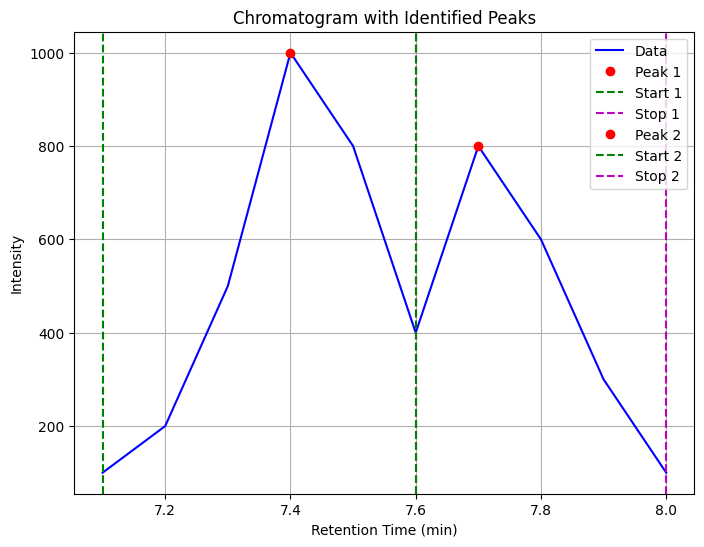

In [2]:
# Perform analysis on each peak
peak_info = []
prev_peak_stop = None
for i, peak_idx in enumerate(peak_indices):
    peak_center = peak_centers[i]
    
    # Determine the peak height
    peak_height = intensity[peak_idx]
    
    # Find the peak start and stop based on intensity fluctuations
    left_idx = peak_idx - 1
    while left_idx > 0 and intensity[left_idx] < intensity[left_idx + 1]:
        left_idx -= 1
    peak_start = retention_time[left_idx]
    
    right_idx = peak_idx + 1
    while right_idx < len(intensity) - 1 and intensity[right_idx] > intensity[right_idx + 1]:
        right_idx += 1
    peak_stop = retention_time[right_idx]
    
    # Update peak start if it comes before the previous peak stop
    if prev_peak_stop is not None and peak_start < prev_peak_stop:
        peak_start = prev_peak_stop
    
    # Calculate the peak width (FWHM)
    half_max = peak_height / 2
    left_half_indices = np.where(intensity[left_idx:peak_idx] < half_max)[0]
    right_half_indices = np.where(intensity[peak_idx:right_idx] < half_max)[0]
    
    if len(left_half_indices) > 0 and len(right_half_indices) > 0:
        left_half_idx = left_half_indices[-1] + left_idx
        right_half_idx = right_half_indices[0] + peak_idx
        fwhm = retention_time[right_half_idx] - retention_time[left_half_idx]
        
        # Perform Gaussian fitting
        p0 = [peak_height, peak_center, fwhm/2.35482]  # Initial parameters
        popt, _ = curve_fit(gaussian, retention_time[left_idx:right_idx+1], intensity[left_idx:right_idx+1], p0=p0)
    else:
        fwhm = None
        popt = None
    
    peak_info.append({
        'peak_number': i + 1,
        'peak_center': peak_center,
        'peak_width': fwhm,
        'peak_height': peak_height,
        'peak_start': peak_start,
        'peak_stop': peak_stop,
        'fitted_params': popt
    })
    
    prev_peak_stop = peak_stop

# Print peak information
for peak in peak_info:
    print(f"Peak {peak['peak_number']}:")
    print("  Peak Center:", peak['peak_center'])
    print("  Peak Width (FWHM):", peak['peak_width'])
    print("  Peak Height:", peak['peak_height'])
    print("  Peak Start:", peak['peak_start'])
    print("  Peak Stop:", peak['peak_stop'])
    print()

# Plot the data and the identified peaks
plt.figure(figsize=(8, 6))
plt.plot(retention_time, intensity, 'b-', label='Data')
for peak in peak_info:
    peak_idx = peak['peak_number'] - 1
    left_idx = np.where(retention_time == peak['peak_start'])[0][0]
    right_idx = np.where(retention_time == peak['peak_stop'])[0][0]
    
    if peak['fitted_params'] is not None:
        popt = peak['fitted_params']
        plt.plot(retention_time[left_idx:right_idx+1], gaussian(retention_time[left_idx:right_idx+1], *popt), 'r-', label=f'Fitted Curve {peak_idx+1}')
    
    plt.plot(peak['peak_center'], intensity[peak_indices[peak_idx]], 'ro', label=f'Peak {peak_idx+1}')
    plt.axvline(x=peak['peak_start'], color='g', linestyle='--', label=f'Start {peak_idx+1}')
    plt.axvline(x=peak['peak_stop'], color='m', linestyle='--', label=f'Stop {peak_idx+1}')

plt.xlabel('Retention Time (min)')
plt.ylabel('Intensity')
plt.title('Chromatogram with Identified Peaks')
plt.legend()
plt.grid(True)
plt.show()

# ChatGPT 2 peaks

Peak 1:
  Peak Start: 7.1
  Peak Center: 7.4
  Peak Stop: 7.5

Peak 2:
  Peak Start: 7.5
  Peak Center: 7.7
  Peak Stop: 7.8



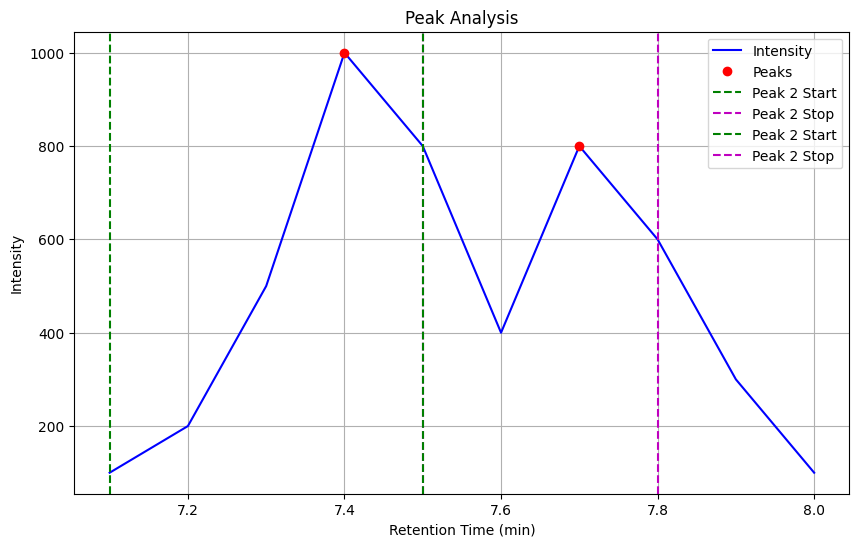

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Example data
retention_time = np.array([7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0])
intensity = np.array([100, 200, 500, 1000, 800, 400, 800, 600, 300, 100])

# Find peaks
peaks, _ = find_peaks(intensity)

# Calculate the gradient of the intensity
gradient = np.gradient(intensity)

# Detect peak start and stops based on the gradient
peak_info = []
for peak_idx in peaks:
    # Start point: move backward from the peak index to find the start
    start_idx = peak_idx
    while start_idx > 0 and not (gradient[start_idx] <= 0 and gradient[start_idx - 1] > 0):
        start_idx -= 1

    # Stop point: move forward from the peak index to find the stop
    stop_idx = peak_idx
    while stop_idx < len(gradient) - 1 and not (gradient[stop_idx] >= 0 and gradient[stop_idx + 1] < 0):
        stop_idx += 1

    # Ensure the start and stop are not the same as the peak index
    if start_idx == peak_idx:
        start_idx = max(0, peak_idx - 1)
    if stop_idx == peak_idx:
        stop_idx = min(len(intensity) - 1, peak_idx + 1)

    peak_info.append({
        'peak_start': retention_time[start_idx],
        'peak_center': retention_time[peak_idx],
        'peak_stop': retention_time[stop_idx]
    })

# Print peak information
for i, peak in enumerate(peak_info, 1):
    print(f"Peak {i}:")
    print("  Peak Start:", peak['peak_start'])
    print("  Peak Center:", peak['peak_center'])
    print("  Peak Stop:", peak['peak_stop'])
    print()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(retention_time, intensity, 'b-', label='Intensity')
plt.plot(retention_time[peaks], intensity[peaks], 'ro', label='Peaks')

for peak in peak_info:
    plt.axvline(x=peak['peak_start'], color='g', linestyle='--', label=f'Peak {i} Start')
    plt.axvline(x=peak['peak_stop'], color='m', linestyle='--', label=f'Peak {i} Stop')

plt.xlabel('Retention Time (min)')
plt.ylabel('Intensity')
plt.title('Peak Analysis')
plt.legend()
plt.grid(True)
plt.show()


# CLAUDE 5 peaks

Peak 1:
  Peak Center: 0.20202020202020202
  Peak Width (FWHM): 0.20202020202020204
  Peak Height: 22.590379102812392
  Peak Start: 0.0
  Peak Stop: 0.40404040404040403

Peak 2:
  Peak Center: 2.121212121212121
  Peak Width (FWHM): None
  Peak Height: 511.8914853300186
  Peak Start: 1.8181818181818181
  Peak Stop: 2.323232323232323

Peak 3:
  Peak Center: 4.141414141414141
  Peak Width (FWHM): None
  Peak Height: 819.5220603044833
  Peak Start: 3.8383838383838382
  Peak Stop: 4.747474747474747

Peak 4:
  Peak Center: 5.454545454545454
  Peak Width (FWHM): None
  Peak Height: 778.5029668152966
  Peak Start: 5.252525252525253
  Peak Stop: 5.555555555555555

Peak 5:
  Peak Center: 5.858585858585858
  Peak Width (FWHM): None
  Peak Height: 725.0479290699881
  Peak Start: 5.656565656565657
  Peak Stop: 6.161616161616162

Peak 6:
  Peak Center: 6.8686868686868685
  Peak Width (FWHM): None
  Peak Height: 955.3131377244755
  Peak Start: 6.161616161616162
  Peak Stop: 6.96969696969697

Peak 7:


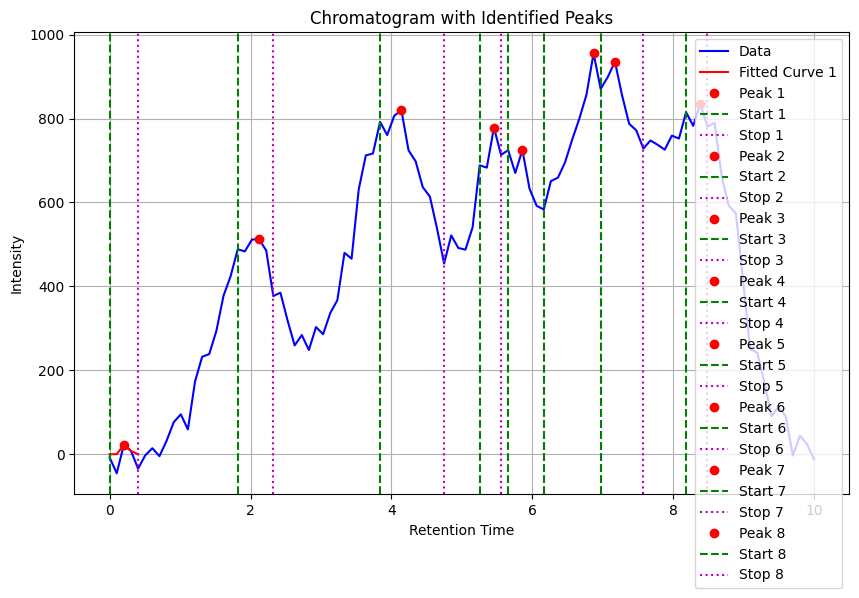

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def gaussian(x, a, b, c):
    return a * np.exp(-(x - b)**2 / (2 * c**2))

# Example data with 100 data points and 5 peaks
retention_time = np.linspace(0, 10, 100)
peak_centers = [2, 4, 5.5, 7, 8.5]
peak_heights = [500, 800, 600, 900, 700]
peak_widths = [0.5, 0.6, 0.4, 0.7, 0.5]

intensity = np.zeros_like(retention_time)
for center, height, width in zip(peak_centers, peak_heights, peak_widths):
    intensity += gaussian(retention_time, height, center, width)

intensity += np.random.normal(0, 30, intensity.shape)  # Add some noise

# Find all peaks
peak_indices, _ = find_peaks(intensity, prominence=50)
peak_centers = retention_time[peak_indices]

# Perform analysis on each peak
peak_info = []
prev_peak_stop = None
for i, peak_idx in enumerate(peak_indices):
    peak_center = peak_centers[i]
    
    # Determine the peak height
    peak_height = intensity[peak_idx]
    
    # Find the peak start and stop based on intensity fluctuations
    left_idx = peak_idx - 1
    while left_idx > 0 and intensity[left_idx] < intensity[left_idx + 1]:
        left_idx -= 1
    peak_start = retention_time[left_idx]
    
    right_idx = peak_idx + 1
    while right_idx < len(intensity) - 1 and intensity[right_idx] > intensity[right_idx + 1]:
        right_idx += 1
    peak_stop = retention_time[right_idx]
    
    # Update peak start if it comes before the previous peak stop
    if prev_peak_stop is not None and peak_start < prev_peak_stop:
        peak_start = prev_peak_stop
    
    # Calculate the peak width (FWHM)
    half_max = peak_height / 2
    left_half_indices = np.where(intensity[left_idx:peak_idx] < half_max)[0]
    right_half_indices = np.where(intensity[peak_idx:right_idx] < half_max)[0]
    
    if len(left_half_indices) > 0 and len(right_half_indices) > 0:
        left_half_idx = left_half_indices[-1] + left_idx
        right_half_idx = right_half_indices[0] + peak_idx
        fwhm = retention_time[right_half_idx] - retention_time[left_half_idx]
        
        # Perform Gaussian fitting
        p0 = [peak_height, peak_center, fwhm/2.35482]  # Initial parameters
        popt, _ = curve_fit(gaussian, retention_time[left_idx:right_idx+1], intensity[left_idx:right_idx+1], p0=p0)
    else:
        fwhm = None
        popt = None
    
    peak_info.append({
        'peak_number': i + 1,
        'peak_center': peak_center,
        'peak_width': fwhm,
        'peak_height': peak_height,
        'peak_start': peak_start,
        'peak_stop': peak_stop,
        'fitted_params': popt
    })
    
    prev_peak_stop = peak_stop

# Print peak information
for peak in peak_info:
    print(f"Peak {peak['peak_number']}:")
    print("  Peak Center:", peak['peak_center'])
    print("  Peak Width (FWHM):", peak['peak_width'])
    print("  Peak Height:", peak['peak_height'])
    print("  Peak Start:", peak['peak_start'])
    print("  Peak Stop:", peak['peak_stop'])
    print()

# Plot the data and the identified peaks
plt.figure(figsize=(10, 6))
plt.plot(retention_time, intensity, 'b-', label='Data')
for peak in peak_info:
    peak_idx = peak['peak_number'] - 1
    left_idx = np.where(retention_time == peak['peak_start'])[0][0]
    right_idx = np.where(retention_time == peak['peak_stop'])[0][0]
    
    if peak['fitted_params'] is not None:
        popt = peak['fitted_params']
        plt.plot(retention_time[left_idx:right_idx+1], gaussian(retention_time[left_idx:right_idx+1], *popt), 'r-', label=f'Fitted Curve {peak_idx+1}')
    
    plt.plot(peak['peak_center'], intensity[peak_indices[peak_idx]], 'ro', label=f'Peak {peak_idx+1}')
    plt.axvline(x=peak['peak_start'], color='g', linestyle='--', label=f'Start {peak_idx+1}')
    plt.axvline(x=peak['peak_stop'], color='m', linestyle='dotted', label=f'Stop {peak_idx+1}')

plt.xlabel('Retention Time')
plt.ylabel('Intensity')
plt.title('Chromatogram with Identified Peaks')
plt.legend()
plt.grid(True)
plt.show()

# ChatGPT 5 peaks

Peak 1:
  Peak Start: 0.40404040404040403
  Peak Center: 1.0101010101010102
  Peak Stop: 1.8181818181818181
  Peak Height: 10.292756779589018
  Peak Apex: 1.0101010101010102
  Peak FWHM: 0.6060606060606061

Peak 2:
  Peak Start: 0.0
  Peak Center: 1.7171717171717171
  Peak Stop: 5.858585858585858
  Peak Height: 1.0043313376456124
  Peak Apex: 1.7171717171717171
  Peak FWHM: 1.4141414141414141

Peak 3:
  Peak Start: 2.2222222222222223
  Peak Center: 3.0303030303030303
  Peak Stop: 3.8383838383838382
  Peak Height: 20.1637978524288
  Peak Apex: 3.0303030303030303
  Peak FWHM: 0.808080808080808

Peak 4:
  Peak Start: 4.343434343434343
  Peak Center: 4.94949494949495
  Peak Stop: 5.656565656565657
  Peak Height: 14.670304057403467
  Peak Apex: 4.94949494949495
  Peak FWHM: 0.7070707070707076

Peak 5:
  Peak Start: 6.161616161616162
  Peak Center: 7.070707070707071
  Peak Stop: 7.878787878787879
  Peak Height: 24.788858651829322
  Peak Apex: 7.070707070707071
  Peak FWHM: 0.808080808080808


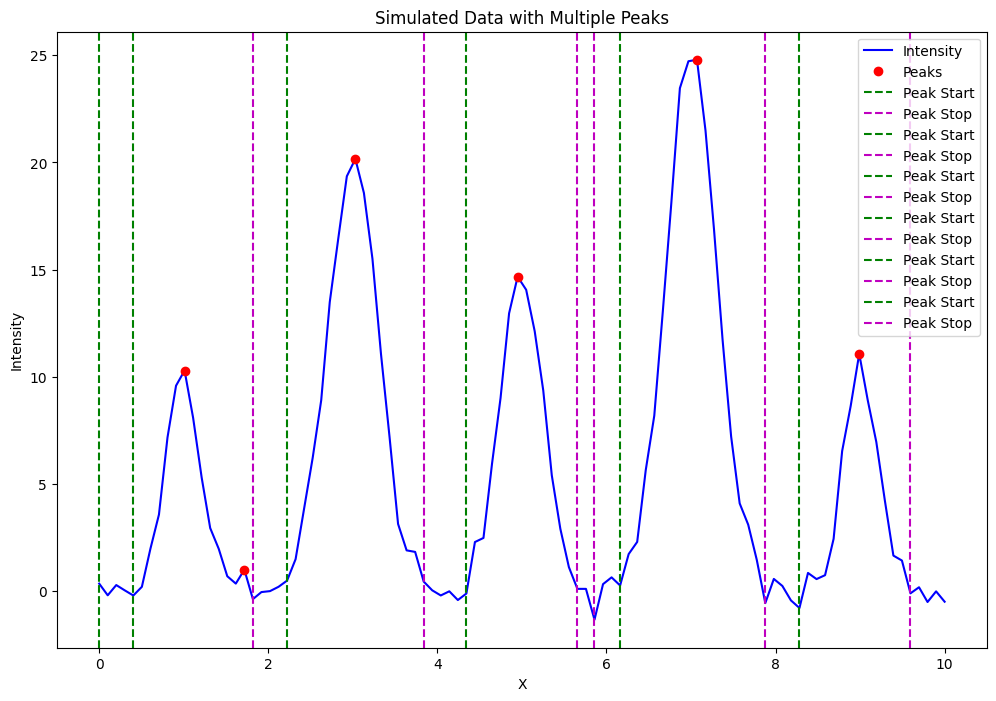

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def gaussian(x, amp, cen, wid):
    """ Returns a Gaussian function for the amp, cen, wid provided """
    return amp * np.exp(-(x-cen)**2 / (2*wid**2))

# Generate data
x = np.linspace(0, 10, 100)
data = (gaussian(x, 10, 1, 0.2) + gaussian(x, 20, 3, 0.3) +
        gaussian(x, 15, 5, 0.25) + gaussian(x, 25, 7, 0.3) +
        gaussian(x, 10, 9, 0.2))
data += np.random.normal(0, 0.5, x.size)

# Find peaks
peaks, properties = find_peaks(data, height=1, distance=5, prominence=0.5)

# Assume baseline is the minimum intensity in the dataset
baseline = np.min(data)

# Detect peak start and stops based on baseline proximity and calculate FWHM
peak_info = []
for peak_idx in peaks:
    # Start point
    start_idx = peak_idx
    while start_idx > 0 and data[start_idx] > baseline + (data[peak_idx] - baseline) * 0.1:
        start_idx -= 1

    # Stop point
    stop_idx = peak_idx
    while stop_idx < len(data) - 1 and data[stop_idx] > baseline + (data[peak_idx] - baseline) * 0.1:
        stop_idx += 1

    # Calculate FWHM
    half_max = (data[peak_idx] + baseline) / 2
    left_idx = np.where(data[:peak_idx] <= half_max)[0][-1]
    right_idx = np.where(data[peak_idx:] <= half_max)[0][0] + peak_idx
    fwhm = x[right_idx] - x[left_idx]

    peak_info.append({
        'peak_start': x[start_idx],
        'peak_center': x[peak_idx],
        'peak_stop': x[stop_idx],
        'peak_height': data[peak_idx],
        'peak_apex': x[peak_idx],
        'peak_FWHM': fwhm
    })

# Print peak information
for i, peak in enumerate(peak_info, 1):
    print(f"Peak {i}:")
    print("  Peak Start:", peak['peak_start'])
    print("  Peak Center:", peak['peak_center'])
    print("  Peak Stop:", peak['peak_stop'])
    print("  Peak Height:", peak['peak_height'])
    print("  Peak Apex:", peak['peak_apex'])
    print("  Peak FWHM:", peak['peak_FWHM'])
    print()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(x, data, 'b-', label='Intensity')
plt.plot(x[peaks], data[peaks], 'ro', label='Peaks')

for peak in peak_info:
    plt.axvline(x=peak['peak_start'], color='g', linestyle='--', label='Peak Start')
    plt.axvline(x=peak['peak_stop'], color='m', linestyle='--', label='Peak Stop')

plt.xlabel('X')
plt.ylabel('Intensity')
plt.title('Simulated Data with Multiple Peaks')
plt.legend()
plt.show()


# ChatGPT working best so far 4/22

Peak 1:
  Peak Start: 0.0
  Peak Center: 1.0101010101010102
  Peak Stop: 10.0
  Peak Height: 9.754199274578498
  Peak Apex: 1.0101010101010102
  Peak FWHM: 0.6060606060606061

Peak 2:
  Peak Start: 2.2222222222222223
  Peak Center: 3.0303030303030303
  Peak Stop: 3.9393939393939394
  Peak Height: 19.57815533592542
  Peak Apex: 3.0303030303030303
  Peak FWHM: 0.9090909090909092

Peak 3:
  Peak Start: 4.141414141414141
  Peak Center: 4.94949494949495
  Peak Stop: 6.0606060606060606
  Peak Height: 15.06429999728693
  Peak Apex: 4.94949494949495
  Peak FWHM: 0.7070707070707076

Peak 4:
  Peak Start: 6.161616161616162
  Peak Center: 6.96969696969697
  Peak Stop: 7.777777777777778
  Peak Height: 24.8320492580959
  Peak Apex: 6.96969696969697
  Peak FWHM: 0.808080808080808

Peak 5:
  Peak Start: 0.0
  Peak Center: 8.98989898989899
  Peak Stop: 10.0
  Peak Height: 9.713912171093462
  Peak Apex: 8.98989898989899
  Peak FWHM: 0.6060606060606055



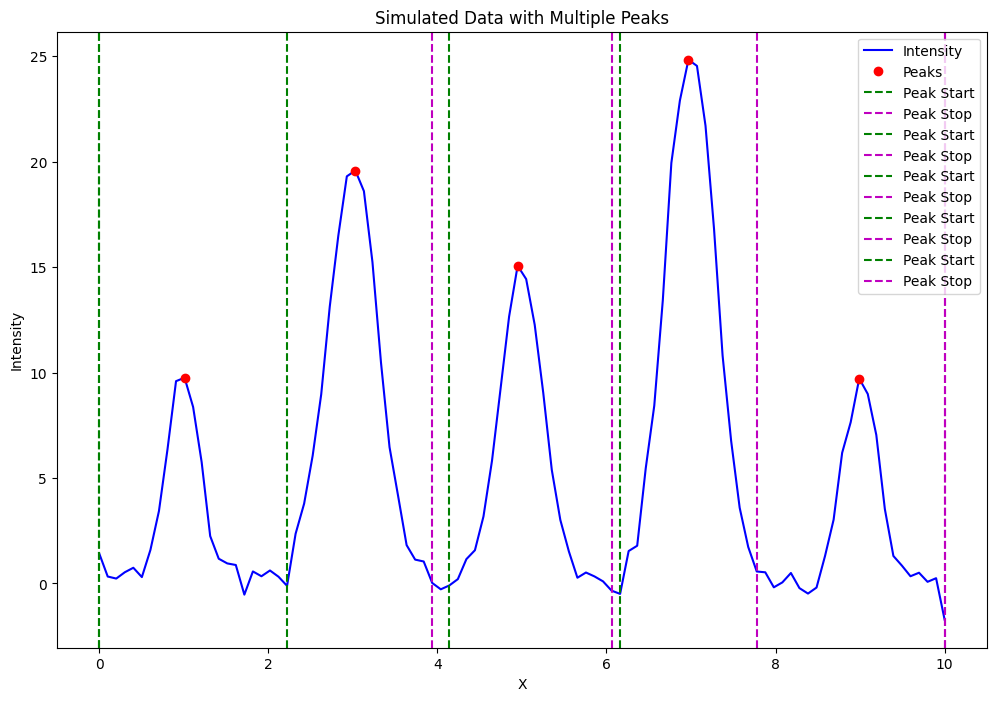

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def gaussian(x, amp, cen, wid):
    """ Returns a Gaussian function for the amp, cen, wid provided """
    return amp * np.exp(-(x-cen)**2 / (2*wid**2))

# Generate data
x = np.linspace(0, 10, 100)
data = (gaussian(x, 10, 1, 0.2) + gaussian(x, 20, 3, 0.3) +
        gaussian(x, 15, 5, 0.25) + gaussian(x, 25, 7, 0.3) +
        gaussian(x, 10, 9, 0.2))
data += np.random.normal(0, 0.5, x.size)

# Baseline and threshold for peak detection
baseline = np.min(data)
threshold_intensity = baseline + 0.1 * (np.max(data) - baseline)  # Adjust this to change detection sensitivity

# Find peaks
peaks, properties = find_peaks(data, height=threshold_intensity, distance=5, prominence=0.5)

# Detect peak start and stops based on baseline proximity and calculate FWHM
peak_info = []
for peak_idx in peaks:
    # Start point
    start_idx = peak_idx
    while start_idx > 0 and data[start_idx] > baseline + (data[peak_idx] - baseline) * 0.1:
        start_idx -= 1

    # Stop point
    stop_idx = peak_idx
    while stop_idx < len(data) - 1 and data[stop_idx] > baseline + (data[peak_idx] - baseline) * 0.1:
        stop_idx += 1

    # Calculate FWHM
    half_max = (data[peak_idx] + baseline) / 2
    left_idx = np.where(data[:peak_idx] <= half_max)[0][-1]
    right_idx = np.where(data[peak_idx:] <= half_max)[0][0] + peak_idx
    fwhm = x[right_idx] - x[left_idx]

    peak_info.append({
        'peak_start': x[start_idx],
        'peak_center': x[peak_idx],
        'peak_stop': x[stop_idx],
        'peak_height': data[peak_idx],
        'peak_apex': x[peak_idx],
        'peak_FWHM': fwhm
    })

# Print peak information
for i, peak in enumerate(peak_info, 1):
    print(f"Peak {i}:")
    print("  Peak Start:", peak['peak_start'])
    print("  Peak Center:", peak['peak_center'])
    print("  Peak Stop:", peak['peak_stop'])
    print("  Peak Height:", peak['peak_height'])
    print("  Peak Apex:", peak['peak_apex'])
    print("  Peak FWHM:", peak['peak_FWHM'])
    print()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(x, data, 'b-', label='Intensity')
plt.plot(x[peaks], data[peaks], 'ro', label='Peaks')

for peak in peak_info:
    plt.axvline(x=peak['peak_start'], color='g', linestyle='--', label='Peak Start')
    plt.axvline(x=peak['peak_stop'], color='m', linestyle='--', label='Peak Stop')

plt.xlabel('X')
plt.ylabel('Intensity')
plt.title('Simulated Data with Multiple Peaks')
plt.legend()
plt.show()


more data points

Peak 1:
  Peak Start: 0.4020100502512563
  Peak Center: 1.0050251256281408
  Peak Stop: 1.7085427135678393
  Peak Height: 10.620599578095183
  Peak Apex: 1.0050251256281408
  Peak FWHM: 0.6030150753768845

Peak 2:
  Peak Start: 2.0100502512562817
  Peak Center: 2.9145728643216082
  Peak Stop: 3.819095477386935
  Peak Height: 19.908269639063153
  Peak Apex: 2.9145728643216082
  Peak FWHM: 0.8040201005025125

Peak 3:
  Peak Start: 4.2211055276381915
  Peak Center: 5.025125628140704
  Peak Stop: 5.628140703517588
  Peak Height: 14.418246978207847
  Peak Apex: 5.025125628140704
  Peak FWHM: 0.7035175879396984

Peak 4:
  Peak Start: 6.231155778894473
  Peak Center: 7.035175879396985
  Peak Stop: 7.738693467336684
  Peak Height: 24.488082495514774
  Peak Apex: 7.035175879396985
  Peak FWHM: 0.8040201005025125

Peak 5:
  Peak Start: 8.341708542713569
  Peak Center: 9.045226130653267
  Peak Stop: 9.748743718592966
  Peak Height: 9.646239702066758
  Peak Apex: 9.045226130653267
  Peak FWHM: 0.5

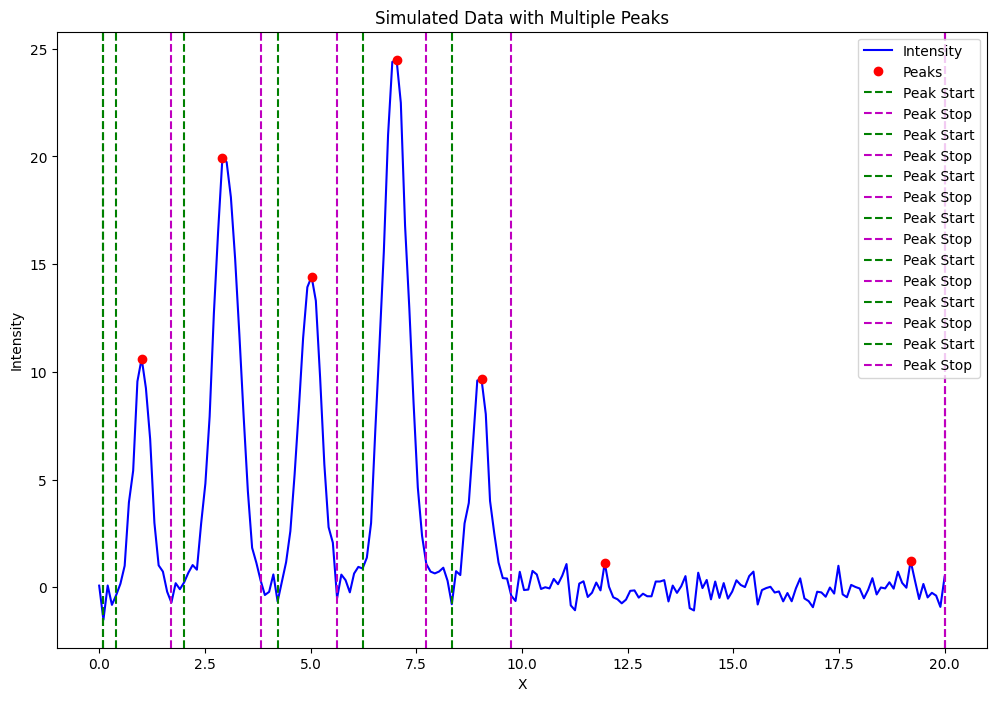

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def gaussian(x, amp, cen, wid):
    """ Returns a Gaussian function for the amp, cen, wid provided """
    return amp * np.exp(-(x-cen)**2 / (2*wid**2))

# Generate data
x = np.linspace(0, 20, 200)
data = (gaussian(x, 10, 1, 0.2) + gaussian(x, 20, 3, 0.3) +
        gaussian(x, 15, 5, 0.25) + gaussian(x, 25, 7, 0.3) +
        gaussian(x, 10, 9, 0.2))
data += np.random.normal(0, 0.5, x.size)

# Baseline and threshold for peak detection
baseline = np.min(data)
threshold_intensity = baseline + 0.1 * (np.max(data) - baseline)  # Adjust this to change detection sensitivity

# Find peaks
peaks, properties = find_peaks(data, height=threshold_intensity, distance=5, prominence=0.5)

# Detect peak start and stops based on baseline proximity and calculate FWHM
peak_info = []
for peak_idx in peaks:
    # Start point
    start_idx = peak_idx
    while start_idx > 0 and data[start_idx] > baseline + (data[peak_idx] - baseline) * 0.1:
        start_idx -= 1

    # Stop point
    stop_idx = peak_idx
    while stop_idx < len(data) - 1 and data[stop_idx] > baseline + (data[peak_idx] - baseline) * 0.1:
        stop_idx += 1

    # Calculate FWHM
    half_max = (data[peak_idx] + baseline) / 2
    left_idx = np.where(data[:peak_idx] <= half_max)[0][-1]
    right_idx = np.where(data[peak_idx:] <= half_max)[0][0] + peak_idx
    fwhm = x[right_idx] - x[left_idx]

    peak_info.append({
        'peak_start': x[start_idx],
        'peak_center': x[peak_idx],
        'peak_stop': x[stop_idx],
        'peak_height': data[peak_idx],
        'peak_apex': x[peak_idx],
        'peak_FWHM': fwhm
    })

# Print peak information
for i, peak in enumerate(peak_info, 1):
    print(f"Peak {i}:")
    print("  Peak Start:", peak['peak_start'])
    print("  Peak Center:", peak['peak_center'])
    print("  Peak Stop:", peak['peak_stop'])
    print("  Peak Height:", peak['peak_height'])
    print("  Peak Apex:", peak['peak_apex'])
    print("  Peak FWHM:", peak['peak_FWHM'])
    print()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(x, data, 'b-', label='Intensity')
plt.plot(x[peaks], data[peaks], 'ro', label='Peaks')

for peak in peak_info:
    plt.axvline(x=peak['peak_start'], color='g', linestyle='--', label='Peak Start')
    plt.axvline(x=peak['peak_stop'], color='m', linestyle='--', label='Peak Stop')

plt.xlabel('X')
plt.ylabel('Intensity')
plt.title('Simulated Data with Multiple Peaks')
plt.legend()
plt.show()


# threshold example

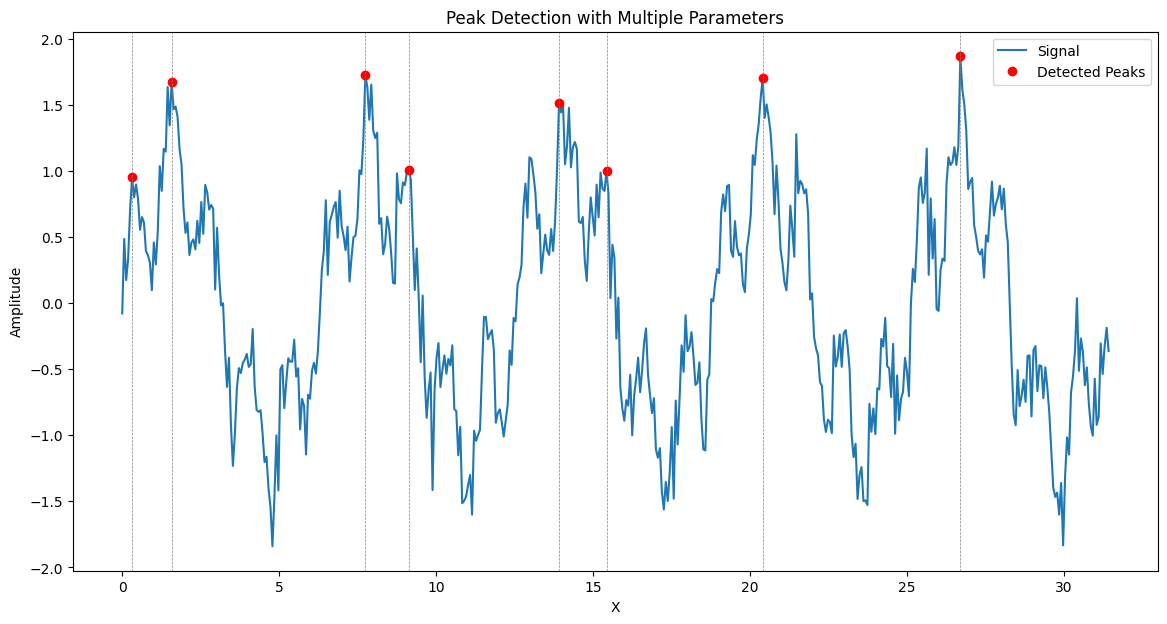

Peak 1:
  Index: 5
  Height: 0.95
  Prominence: 0.86
  Width: 7.88 (at rel_height=0.5)
  Plateau Size: N/A

Peak 2:
  Index: 25
  Height: 1.67
  Prominence: 1.69
  Width: 12.10 (at rel_height=0.5)
  Plateau Size: N/A

Peak 3:
  Index: 123
  Height: 1.72
  Prominence: 1.63
  Width: 9.80 (at rel_height=0.5)
  Plateau Size: N/A

Peak 4:
  Index: 145
  Height: 1.01
  Prominence: 0.86
  Width: 8.32 (at rel_height=0.5)
  Plateau Size: N/A

Peak 5:
  Index: 221
  Height: 1.52
  Prominence: 1.35
  Width: 11.05 (at rel_height=0.5)
  Plateau Size: N/A

Peak 6:
  Index: 245
  Height: 1.00
  Prominence: 0.83
  Width: 7.12 (at rel_height=0.5)
  Plateau Size: N/A

Peak 7:
  Index: 324
  Height: 1.70
  Prominence: 1.67
  Width: 11.08 (at rel_height=0.5)
  Plateau Size: N/A

Peak 8:
  Index: 424
  Height: 1.87
  Prominence: 1.88
  Width: 10.73 (at rel_height=0.5)
  Plateau Size: N/A



In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Generate data
x = np.linspace(0, 10*np.pi, 500)
data = np.sin(x) + 0.5*np.sin(5*x) + 0.2*np.random.normal(size=x.size)

# Parameters for peak detection
height = (0.2, None)  # Minimum and maximum height to consider for peaks
threshold = 0       # Vertical distance to its neighboring samples
distance = 20         # Minimum number of samples between neighboring peaks
prominence = 0.3     # Required prominence of peaks
width = (7, 20)       # Width range of the peaks in samples
rel_height = 0.5      # Relative height for calculating the width
plateau_size = None   # Size of the flat top of the peaks
wlen = 50             # Window length for calculating peak properties

# Finding peaks
peaks, properties = find_peaks(data, height=height, threshold=threshold,
                               distance=distance, prominence=prominence,
                               width=width, plateau_size=plateau_size,
                               rel_height=rel_height, wlen=wlen)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(x, data, label='Signal')
plt.plot(x[peaks], data[peaks], 'ro', label='Detected Peaks')
for i, peak in enumerate(peaks):
    plt.axvline(x=x[peak], color='gray', linestyle='--', lw=0.5)
plt.title('Peak Detection with Multiple Parameters')
plt.xlabel('X')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Printing peak properties
for i, peak in enumerate(peaks):
    print(f"Peak {i+1}:")
    print(f"  Index: {peak}")
    print(f"  Height: {data[peak]:.2f}")
    print(f"  Prominence: {properties['prominences'][i]:.2f}")
    print(f"  Width: {properties['widths'][i]:.2f} (at rel_height={rel_height})")
    print(f"  Plateau Size: {properties['plateau_sizes'][i] if plateau_size else 'N/A'}")
    print()


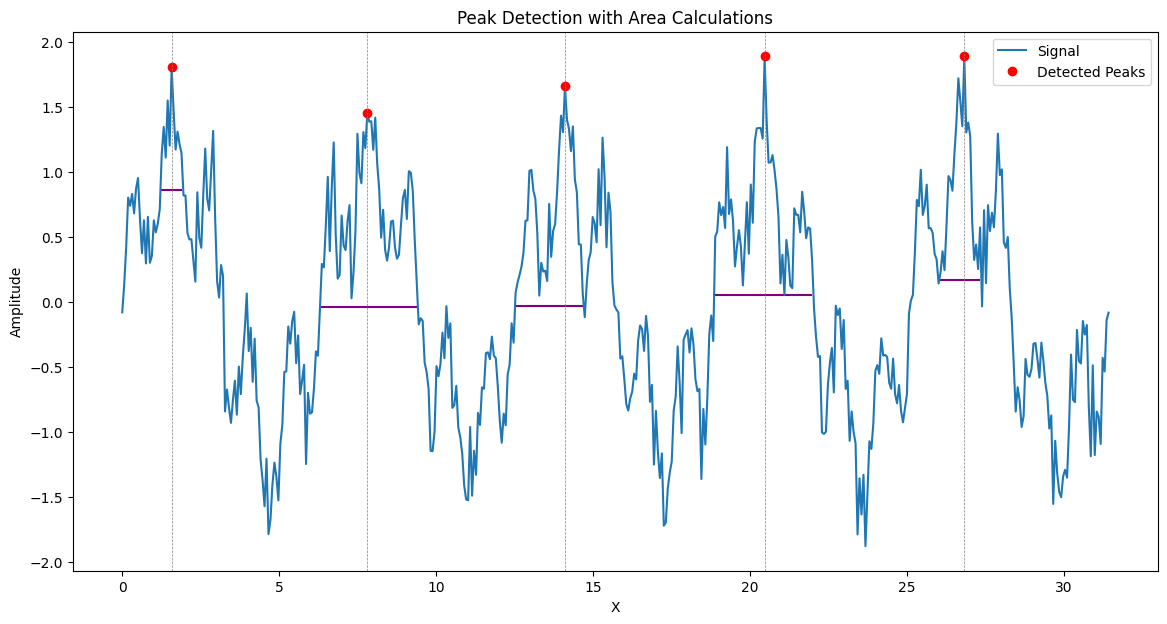

Peak 1:
  Index: 25
  Height: 1.81
  Prominence: 1.77
  Width: 11.52 (at rel_height=0.5)
  FWHM Area: 20.82
  Trapezoidal Area: 10.72

Peak 2:
  Index: 124
  Height: 1.45
  Prominence: 1.30
  Width: 49.50 (at rel_height=0.5)
  FWHM Area: 72.00
  Trapezoidal Area: 2.26

Peak 3:
  Index: 224
  Height: 1.66
  Prominence: 1.61
  Width: 34.75 (at rel_height=0.5)
  FWHM Area: 57.81
  Trapezoidal Area: -4.43

Peak 4:
  Index: 325
  Height: 1.89
  Prominence: 1.76
  Width: 50.29 (at rel_height=0.5)
  FWHM Area: 95.03
  Trapezoidal Area: 0.64

Peak 5:
  Index: 426
  Height: 1.89
  Prominence: 1.75
  Width: 21.36 (at rel_height=0.5)
  FWHM Area: 40.41
  Trapezoidal Area: 7.67



In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths

# Generate data
x = np.linspace(0, 10*np.pi, 500)
data = np.sin(x) + 0.5*np.sin(5*x) + 0.2*np.random.normal(size=x.size)

# Parameters for peak detection
height = (0.2, None)  # Minimum and maximum height to consider for peaks
threshold = 0         # Vertical distance to its neighboring samples
distance = 20         # Minimum number of samples between neighboring peaks ###
prominence = 0.3      # Required prominence of peaks
width = (7)       # Width range of the peaks in samples ###
rel_height = 0.5      # Relative height for calculating the width #
plateau_size = None   # Size of the flat top of the peaks
wlen = 50             # Window length for calculating peak properties

# Finding peaks
peaks, properties = find_peaks(data, height=height, threshold=threshold,
                               distance=distance, prominence=prominence,
                               width=width, plateau_size=plateau_size,
                               rel_height=rel_height, wlen=wlen)

# Calculate widths using the full width at half maximum
fw_widths = peak_widths(data, peaks, rel_height=0.5)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(x, data, label='Signal')
plt.plot(x[peaks], data[peaks], 'ro', label='Detected Peaks')
for i, peak in enumerate(peaks):
    plt.axvline(x=x[peak], color='gray', linestyle='--', lw=0.5)
    plt.hlines(y=fw_widths[1][i], xmin=x[int(fw_widths[2][i])], xmax=x[int(fw_widths[3][i])], color='purple')
plt.title('Peak Detection with Area Calculations')
plt.xlabel('X')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Calculate and print peak properties and areas
for i, peak in enumerate(peaks):
    print(f"Peak {i+1}:")
    print(f"  Index: {peak}")
    print(f"  Height: {data[peak]:.2f}")
    print(f"  Prominence: {properties['prominences'][i]:.2f}")
    print(f"  Width: {fw_widths[0][i]:.2f} (at rel_height={rel_height})")
    
    # FWHM area calculation
    fwhm_area = data[peak] * fw_widths[0][i]
    print(f"  FWHM Area: {fwhm_area:.2f}")

    # Trapezoidal area calculation
    base1 = data[int(fw_widths[2][i])]  # height at left width index
    base2 = data[int(fw_widths[3][i])]  # height at right width index
    trapezoidal_area = 0.5 * (base1 + base2) * fw_widths[0][i]
    print(f"  Trapezoidal Area: {trapezoidal_area:.2f}")

    print()
